In [1]:
%matplotlib inline
import rasterio as rio
from rasterio import features
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
import pandas as pd
from datetime import datetime
from shapely.geometry import shape
import geopandas as gpd

sys.path.append(os.path.join(os.path.abspath(''), "../"))
from src import get_affine, get_metadata, vectorize_raster

In [2]:
target_date = [
    datetime.strptime("20200101", "%Y%m%d"),
    datetime.strptime("20201231", "%Y%m%d")
]

data_root = os.path.join("..", "data", "Karachi")
flist = glob.glob(os.path.join(data_root, "*"))

filtered_flist = []
for fname in flist:
    dt = get_metadata(fname)["date"]
    if dt > target_date[0] and dt < target_date[1]:
        filtered_flist.append(fname)


In [3]:
month_list = [get_metadata(fname)["date"].month for fname in filtered_flist]
datetime_list = [get_metadata(fname)["date"] for fname in filtered_flist]

master_df = pd.DataFrame({
    "fname": filtered_flist,
    "month": month_list,
    "datetime": datetime_list
})

master_df.head()

,fname,month,datetime
0,../data/Karachi/S1A_IW_GRDH_1SDV_20201117T1335...,11,2020-11-17 13:35:33
1,../data/Karachi/S1A_IW_GRDH_1SDV_20200521T1335...,5,2020-05-21 13:35:26
2,../data/Karachi/S1A_IW_GRDH_1SDV_20200509T1335...,5,2020-05-09 13:35:26
3,../data/Karachi/S1A_IW_GRDH_1SDV_20201211T1335...,12,2020-12-11 13:35:32
4,../data/Karachi/S1A_IW_GRDH_1SDV_20201129T1335...,11,2020-11-29 13:35:33


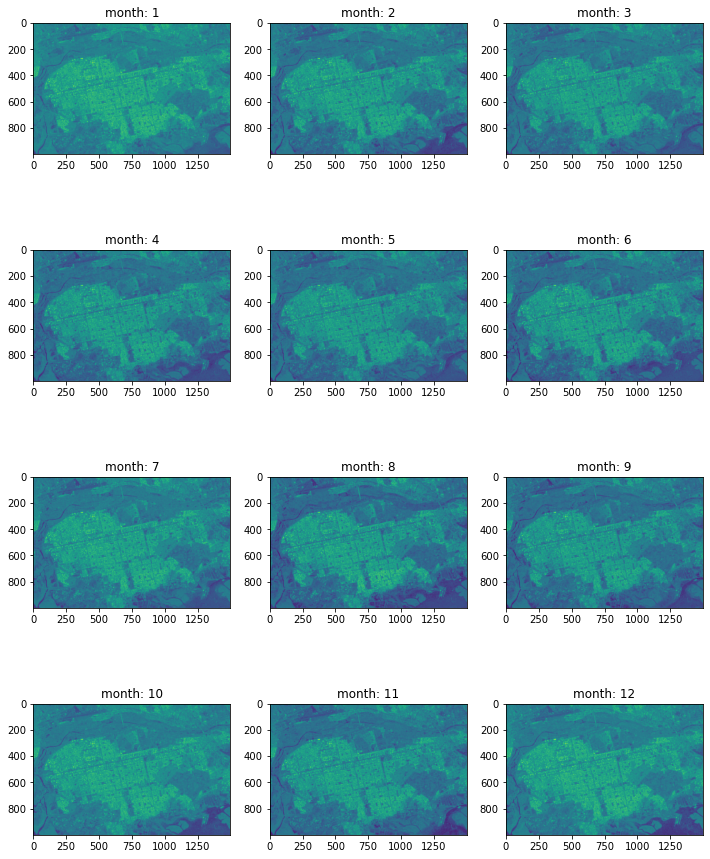

In [4]:
m = master_df["month"].unique()
m.sort()

x = [1000, 2000]
y = [2000, 3500]

VV_imgs = []

fig = plt.figure(figsize=(12, 16))

for i in m:
    img_mean = np.zeros((x[1] - x[0], y[1] - y[0]))
    m_i_list = list(master_df[master_df["month"] == i]["fname"])
    for img in m_i_list:
        with rio.open(img) as src:
            VV = src.read(1)
        img_mean += VV[x[0]:x[1], y[0]:y[1]]
    img_mean = img_mean/len(m_i_list)
    VV_imgs.append(img_mean)

    ax = plt.subplot(4, 3, i)
    ax.set_title(f"month: {i}")
    ax.imshow(img_mean)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

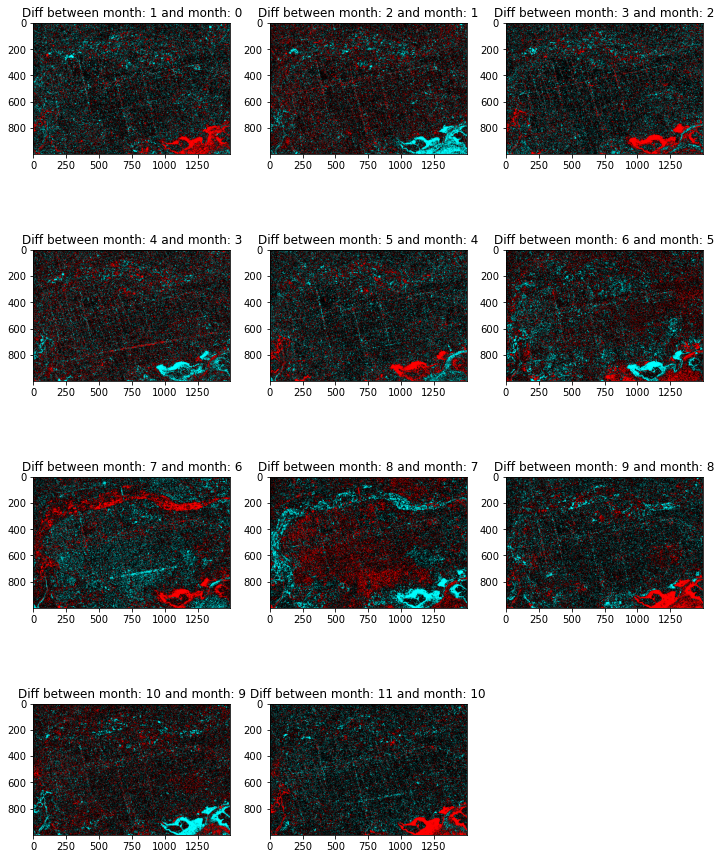

In [5]:
sigma = 1

fig = plt.figure(figsize=(12, 16))

for i in range(len(VV_imgs)):
    if i != 0:
        diff = VV_imgs[i] - VV_imgs[i-1]
        mean = diff.mean()
        std = diff.std()
        normalized = (diff - mean)/std

        removed = np.where(diff < mean - sigma*std, -1*normalized, np.nan)
        constructed = np.where(diff > mean + sigma*std, normalized, np.nan)

        removed = np.clip(removed * 255/4, 0, 255).astype(int)
        constructed = np.clip(constructed * 255/4, 0, 255).astype(int)

        ax = plt.subplot(4, 3, i)
        ax.set_title(f"Diff between month: {i} and month: {i-1}")
        ax.imshow(np.array([removed, constructed, constructed]).transpose(1, 2, 0)*255)

In [6]:
transform = get_affine(m_i_list[0], x, y)

In [19]:
sigma = 1.5
thresh_sigma = 5
output_root = os.path.join("..", "output", "raster")
os.makedirs(output_root, exist_ok=True)

fig = plt.figure(figsize=(12, 16))

for i in range(len(VV_imgs)):
    if i != 0:
        diff = VV_imgs[i] - VV_imgs[i-1]
        mean = diff.mean()
        std = diff.std()
        normalized = (diff - mean)/std

        removed = np.where(diff < mean - sigma*std, -1*normalized, 0)
        constructed = np.where(diff > mean + sigma*std, normalized, 0)

        removed = np.clip(removed * 255/thresh_sigma, 0, 255).astype(np.uint8)
        constructed = np.clip(constructed * 255/thresh_sigma, 0, 255).astype(np.uint8)

        img = np.array([removed, constructed, constructed])

        fname = os.path.join(output_root,
                             f"month{i}-month{i+1}.tif")

        with rio.open(
            fname,
            "w",
            driver="GTiff",
            dtype=np.uint8,
            height=x[1] - x[0],
            width=y[1] - y[0],
            count=3,
            crs=src.crs,
            transform=transform,
        ) as dst:

            dst.write(img)
        print(f"Finish: {fname}")

Finish: ../output/raster/month1-month2.tif
Finish: ../output/raster/month2-month3.tif
Finish: ../output/raster/month3-month4.tif
Finish: ../output/raster/month4-month5.tif
Finish: ../output/raster/month5-month6.tif
Finish: ../output/raster/month6-month7.tif
Finish: ../output/raster/month7-month8.tif
Finish: ../output/raster/month8-month9.tif
Finish: ../output/raster/month9-month10.tif
Finish: ../output/raster/month10-month11.tif
Finish: ../output/raster/month11-month12.tif


<Figure size 864x1152 with 0 Axes>